# **CENG 442 - Natural Language Processing**

## Assignment 1

### Emirhan Aslankarayiğit

**Required Libraries**

In [1]:
!pip install pandas gensim openpyxl regex ftfy scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.9 MB/s eta 0:00:00


**Import Those Libraries**

In [2]:
import re, html, unicodedata
import pandas as pd
from pathlib import Path

try:
  from ftfy import fix_text
except Exception:
  def fix_text(s): return s

*A common preprocessing step in Natural Language Processing (NLP) pipelines is the conversion of all text to lowercase. This normalization technique is employed to reduce the vocabulary size and ensure uniformity, which simplifies subsequent analytical tasks.*

In [3]:
def lower_az(s: str) -> str:
  if not isinstance(s, str): return ""
  s = unicodedata.normalize("NFC", s)
  s = s.replace("I", "ı").replace("İ", "i")
  s = s.lower().replace("i̇","i")
  return s

*The next cell defines regex patterns and mapping dictionaries to clean and normalize text data before analysis. It removes noise such as HTML tags, URLs, and emojis while standardizing slang and negation, ensuring consistent and semantically rich text representations for modeling.*

In [4]:
HTML_TAG_RE = re.compile(r"<[^>]+>")
URL_RE = re.compile(r"(https?://\S+|www\.\S+)", re.IGNORECASE)
EMAIL_RE = re.compile(r"\b[\w\.-]+@[\w\.-]+\.\w+\b", re.IGNORECASE)
PHONE_RE = re.compile(r"\+?\d[\d\-\s\(\)]{6,}\d")
USER_RE = re.compile(r"@\w+")
MULTI_PUNCT = re.compile(r"([!?.,;:])\1{1,}")
MULTI_SPACE = re.compile(r"\s+")
REPEAT_CHARS = re.compile(r"(.)\1{2,}", flags=re.UNICODE)
TOKEN_RE = re.compile(r"[A-Za-zƏəĞğIıİiÖöÜüÇçŞşXxQq]+(?:'[A-Za-zƏəĞğIıİiÖöÜüÇçŞşXxQq]+)?" r"|<NUM>|URL|EMAIL|PHONE|USER|EMO_(?:POS|NEG)")

#Unicode based on the all specified emogy
EMO_MAP = {
    "\U0001F642": "EMO_POS",
    "\U0001F60A": "EMO_POS",
    "\U0001F60D": "EMO_POS",
    "\U0001F60E": "EMO_POS",
    "\U0001F44D": "EMO_POS",

    "\u2639":     "EMO_NEG",
    "\U0001F641": "EMO_NEG",
    "\U0001F61E": "EMO_NEG",
    "\U0001F620": "EMO_NEG",
    "\U0001F44E": "EMO_NEG",
}
SLANG_MAP = {"slm":"salam","tmm":"tamam","sagol":"sağol","cox":"çox","yaxsi":"yaxşı"}
NEGATORS = {"yox","deyil","heç","qətiyyən","yoxdur"}

*This cell defines domain-specific regex patterns to detect news, social, and review indicators, as well as price and rating expressions within Azerbaijani text.*

In [5]:
import re
NEWS_HINTS = re.compile(r"\b(apa|trend|azertac|reuters|bloomberg|dha|aa)\b", re.I)
SOCIAL_HINTS = re.compile(r"\b(rt)\b|@|#|(?:\U0001F602|\U0001F60D|\U0001F60A|\U0001F44D|\U0001F44E|\U0001F621|\U0001F642)")
REV_HINTS = re.compile(r"\b(azn|manat|qiymət|aldım|ulduz|çox yaxşı|çox pis)\b", re.I)
PRICE_RE = re.compile(r"\b\d+\s*(azn|manat)\b", re.I)
STARS_RE = re.compile(r"\b([1-5])\s*ulduz\b", re.I)
POS_RATE = re.compile(r"\bçox yaxşı\b")
NEG_RATE = re.compile(r"\bçox pis\b")

* ***detect_domain(text: str)*** detects the most probable domain of a text (news, social, reviews, or general) based on predefined lexical and regex patterns.*

In [6]:
def detect_domain(text: str) -> str:
  s = text.lower()
  if(NEWS_HINTS.search(s)): return "news"
  if(SOCIAL_HINTS.search(s)): return "social"
  if(REV_HINTS.search(s)): return "reviews"
  return "general"

***domain_specific_normalize(cleaned: str, domain: str)*** applies domain-specific normalization rules, replacing price and rating expressions in review texts with standardized tokens for consistent semantic representation.

In [7]:
def domain_specific_normalize(cleaned: str, domain: str) -> str:
  if domain == "reviews":
    s = PRICE_RE.sub("PRICE", cleaned)
    s = STARS_RE.sub(lambda m: f" <STARS_{m.group(1)}> ", cleaned)
    s = POS_RATE.sub(" <RATING_POS> ", s)
    s = NEG_RATE.sub(" <RATING_NEG> ", s)
    return " ".join(s.split())
  return cleaned

***add_domain_tag(line: str, domain: str)** prepends a domain identifier (e.g., domnews, domsocial) to each text line, enabling domain-aware representation within the corpus.*

In [8]:
def add_domain_tag(line: str, domain: str) -> str:
  return f"dom{domain} " + line

***normalize_text_az(s: str, numbers_to_token=True, keep_sentence_punct=False)** performs comprehensive text normalization for Azerbaijani, converting emojis, HTML, URLs, and slang into standardized tokens while handling negation propagation and preserving sentence punctuation as configured.*

In [9]:
def normalize_text_az(s: str, numbers_to_token=True, keep_sentence_punct=False) -> str:
  if not isinstance(s, str): return ""
  for emo, tag in EMO_MAP.items():
    s = s.replace(emo, f" {tag} ")
  s = fix_text(s)
  s = html.unescape(s)
  s = HTML_TAG_RE.sub(" ", s)
  s = URL_RE.sub(" URL ", s)
  s = EMAIL_RE.sub(" EMAIL ", s)
  s = PHONE_RE.sub(" PHONE ", s)
  s = re.sub(r"#([A-Za-z0-9_]+)", lambda m: " " + re.sub('([a-z])([A-Z])', r'\1 \2',m.group(1)) + " ", s)
  s = USER_RE.sub(" USER ", s)
  s = lower_az(s)
  s = MULTI_PUNCT.sub(r"\1", s)
  if numbers_to_token:
    s = re.sub(r"\d+", " <NUM> ", s)
  if keep_sentence_punct:
    s = re.sub(r"[^\w\s<>'əğıöşüçƏĞIİÖŞÜÇxqXQ.!?]", " ", s)
  else:
    s = re.sub(r"[^\w\s<>'əğıöşüçƏĞIİÖŞÜÇxqXQ]", " ", s)
  s = MULTI_SPACE.sub(" ", s).strip()
  toks = TOKEN_RE.findall(s)
  norm = []
  mark_neg = 0
  for t in toks:
    t = REPEAT_CHARS.sub(r"\1\1", t)
    t = SLANG_MAP.get(t, t)
    if t in NEGATORS:
      norm.append(t); mark_neg = 3; continue
    if mark_neg > 0 and t not in {"URL","EMAIL","PHONE","USER"}:
      norm.append(t + "_NEG"); mark_neg -= 1
    else:
      norm.append(t)
  norm = [t for t in norm if not (len(t) == 1 and t not in {"o","e"})]
  return " ".join(norm).strip()

***map_sentiment_value(...)** standardizes diverse sentiment label formats across datasets by mapping various linguistic and numeric expressions (e.g., **positive**, **1**, **müsbət**) into unified numeric values:*
* 1.0 for positive,
* 0.5 for neutral,
* 0.0 for negative.

In [10]:
def map_sentiment_value(v, scheme: str):
    if v is None:
        return None

    s = str(v).strip().lower()
    if not s:
        return None

    if s in {"pos", "positive", "1", "müsbət", "good", "pozitiv"}:
        return 1.0

    if s in {"neg", "negative", "0", "mənfi", "bad", "neqativ"}:
        return 0.0

    if s in {"neu", "neutral", "2", "neytral"}:
        return 0.5

    return None

***process_file(...)** processes a given dataset by cleaning and normalizing text, detecting its domain, optionally removing stopwords, mapping sentiment labels to numeric values, and exporting a standardized two-column Excel file (cleaned_text, sentiment_value) for downstream analysis.*

In [11]:
def process_file(in_path, text_col, label_col, scheme, out_two_col_path,remove_stopwords=False):
  df = pd.read_excel(in_path)
  for c in ["Unnamed: 0","index"]:
    if c in df.columns: df = df.drop(columns=[c])
  assert text_col in df.columns and label_col in df.columns, f"Missing columns in {in_path}"
  df = df.dropna(subset=[text_col])
  df = df[df[text_col].astype(str).str.strip().str.len() > 0]
  df = df.drop_duplicates(subset=[text_col])
  df["cleaned_text"] = df[text_col].astype(str).apply(lambda s: normalize_text_az(s))
  df["__domain__"] = df[text_col].astype(str).apply(detect_domain)
  df["cleaned_text"] = df.apply(lambda r: domain_specific_normalize(r["cleaned_text"], r["__domain__"]), axis=1)

  sw = set()
  if remove_stopwords:
    sw = set(["və","ilə","amma","ancaq","lakin","ya","həm","ki","bu","bir","o","biz","siz","mən","sən","orada","burada","bütün","hər","artıq","çox","az","ən","də","da","üçün"])

  for keep in ["deyil","yox","heç","qətiyyən","yoxdur"]:
    sw.discard(keep)
  df["cleaned_text"] = df["cleaned_text"].apply(lambda s: " ".join([t for t in s.split() if t not in sw]))
  df["sentiment_value"] = df[label_col].apply(lambda v: map_sentiment_value(v, scheme))
  df = df.dropna(subset=["sentiment_value"])
  df["sentiment_value"] = df["sentiment_value"].astype(float)
  out_df = df[["cleaned_text","sentiment_value"]].reset_index(drop=True)
  Path(out_two_col_path).parent.mkdir(parents=True, exist_ok=True)
  out_df.to_excel(out_two_col_path, index=False)
  print(f"Saved: {out_two_col_path} (rows={len(out_df)})")

***build_corpus_txt(...)** constructs a unified domain-tagged corpus by reading cleaned text from multiple datasets, segmenting sentences, removing punctuation, lowercasing, and prefixing each line with its detected domain label before saving to a single text file.*

In [12]:
def build_corpus_txt(input_files, text_cols, out_txt="corpus_all.txt"):
    """Create domain-tagged, lowercase, punctuation-free corpus (one sentence per
    line)."""
    lines = []
    for (f, text_col) in zip(input_files, text_cols):
        df = pd.read_excel(f)
        for raw in df[text_col].dropna().astype(str):
            dom = detect_domain(raw)
            s = normalize_text_az(raw, keep_sentence_punct=True)
            parts = re.split(r"[.!?]+", s)
            for p in parts:
                p = p.strip()
                if not p: continue
                p = re.sub(r"[^\w\səğıöşüçƏĞIİÖŞÜÇxqXQ]", " ", p)
                p = " ".join(p.split()).lower()
                if p:
                    lines.append(f"dom{dom} " + p)

    with open(out_txt, "w", encoding="utf-8") as w:
        for ln in lines:
            w.write(ln + "\n")
    print(f"Wrote {out_txt} with {len(lines)} lines")

This next cell executes the full preprocessing pipeline:
- iterating over all dataset configurations,
- cleaning and normalizing each file to generate two-column outputs (cleaned_text, sentiment_value),
- finally combining them into a unified, domain-tagged corpus (corpus_all.txt) for model training.

In [13]:
if __name__ == "__main__":
    CFG = [
        ("labeled-sentiment.xlsx",
         "text", "sentiment", "tri"),
        ("test__1_.xlsx",
         "text", "label",
         "binary"),
        ("train__3_.xlsx",
         "text", "label",
         "binary"),
        ("train-00000-of-00001.xlsx",
         "text", "labels",
         "tri"),
        ("merged_dataset_CSV__1_.xlsx",
         "text", "labels",
         "binary"),
    ]
    for fname, tcol, lcol, scheme in CFG:
        out = f"{Path(fname).stem}_2col.xlsx"
        process_file(fname, tcol, lcol, scheme, out, remove_stopwords=False)
    build_corpus_txt([c[0] for c in CFG], [c[1] for c in CFG],
                     out_txt="corpus_all.txt")

Saved: labeled-sentiment_2col.xlsx (rows=2955)
Saved: test__1__2col.xlsx (rows=4198)
Saved: train__3__2col.xlsx (rows=19557)
Saved: train-00000-of-00001_2col.xlsx (rows=41756)
Saved: merged_dataset_CSV__1__2col.xlsx (rows=55662)
Wrote corpus_all.txt with 124353 lines


The next one trains two word embedding models — ***[Word2Vec](https://arxiv.org/pdf/1301.3781)*** and ***[FastText](https://arxiv.org/pdf/1607.01759)*** — using all cleaned text sentences from the preprocessed datasets. Both models employ:
- *skip-gram architecture* (sg=1) with 300-dimensional vectors,
- a context window of 5,
- are trained for 10 epochs
- the resulting embeddings are saved in the embeddings directory for subsequent evaluation.

In [14]:
from gensim.models import Word2Vec, FastText
import pandas as pd
from pathlib import Path

files = [
    "labeled-sentiment_2col.xlsx",
    "test__1__2col.xlsx",
    "train__3__2col.xlsx",
    "train-00000-of-00001_2col.xlsx",
    "merged_dataset_CSV__1__2col.xlsx",
]

sentences = []
for f in files:
    df = pd.read_excel(f, usecols=["cleaned_text"])
    sentences.extend(df["cleaned_text"].astype(str).str.split().tolist())

Path("embeddings").mkdir(exist_ok=True)
w2v = Word2Vec(sentences=sentences, vector_size=300, window=5, min_count=3, sg=1,
               negative=10, epochs=10)
w2v.save("embeddings/word2vec.model")
ft = FastText(sentences=sentences, vector_size=300, window=5, min_count=3, sg=1,
              min_n=3, max_n=6, epochs=10)
ft.save("embeddings/fasttext.model")
print("Saved embeddings.")

Saved embeddings.


This cell benchmarks the **semantic quality** of the trained Word2Vec and FastText models.  
It evaluates **lexical coverage** (ratio of in-vocabulary tokens) and computes **cosine similarity** between embedding vectors for synonym and antonym word pairs, mathematically expressed as:

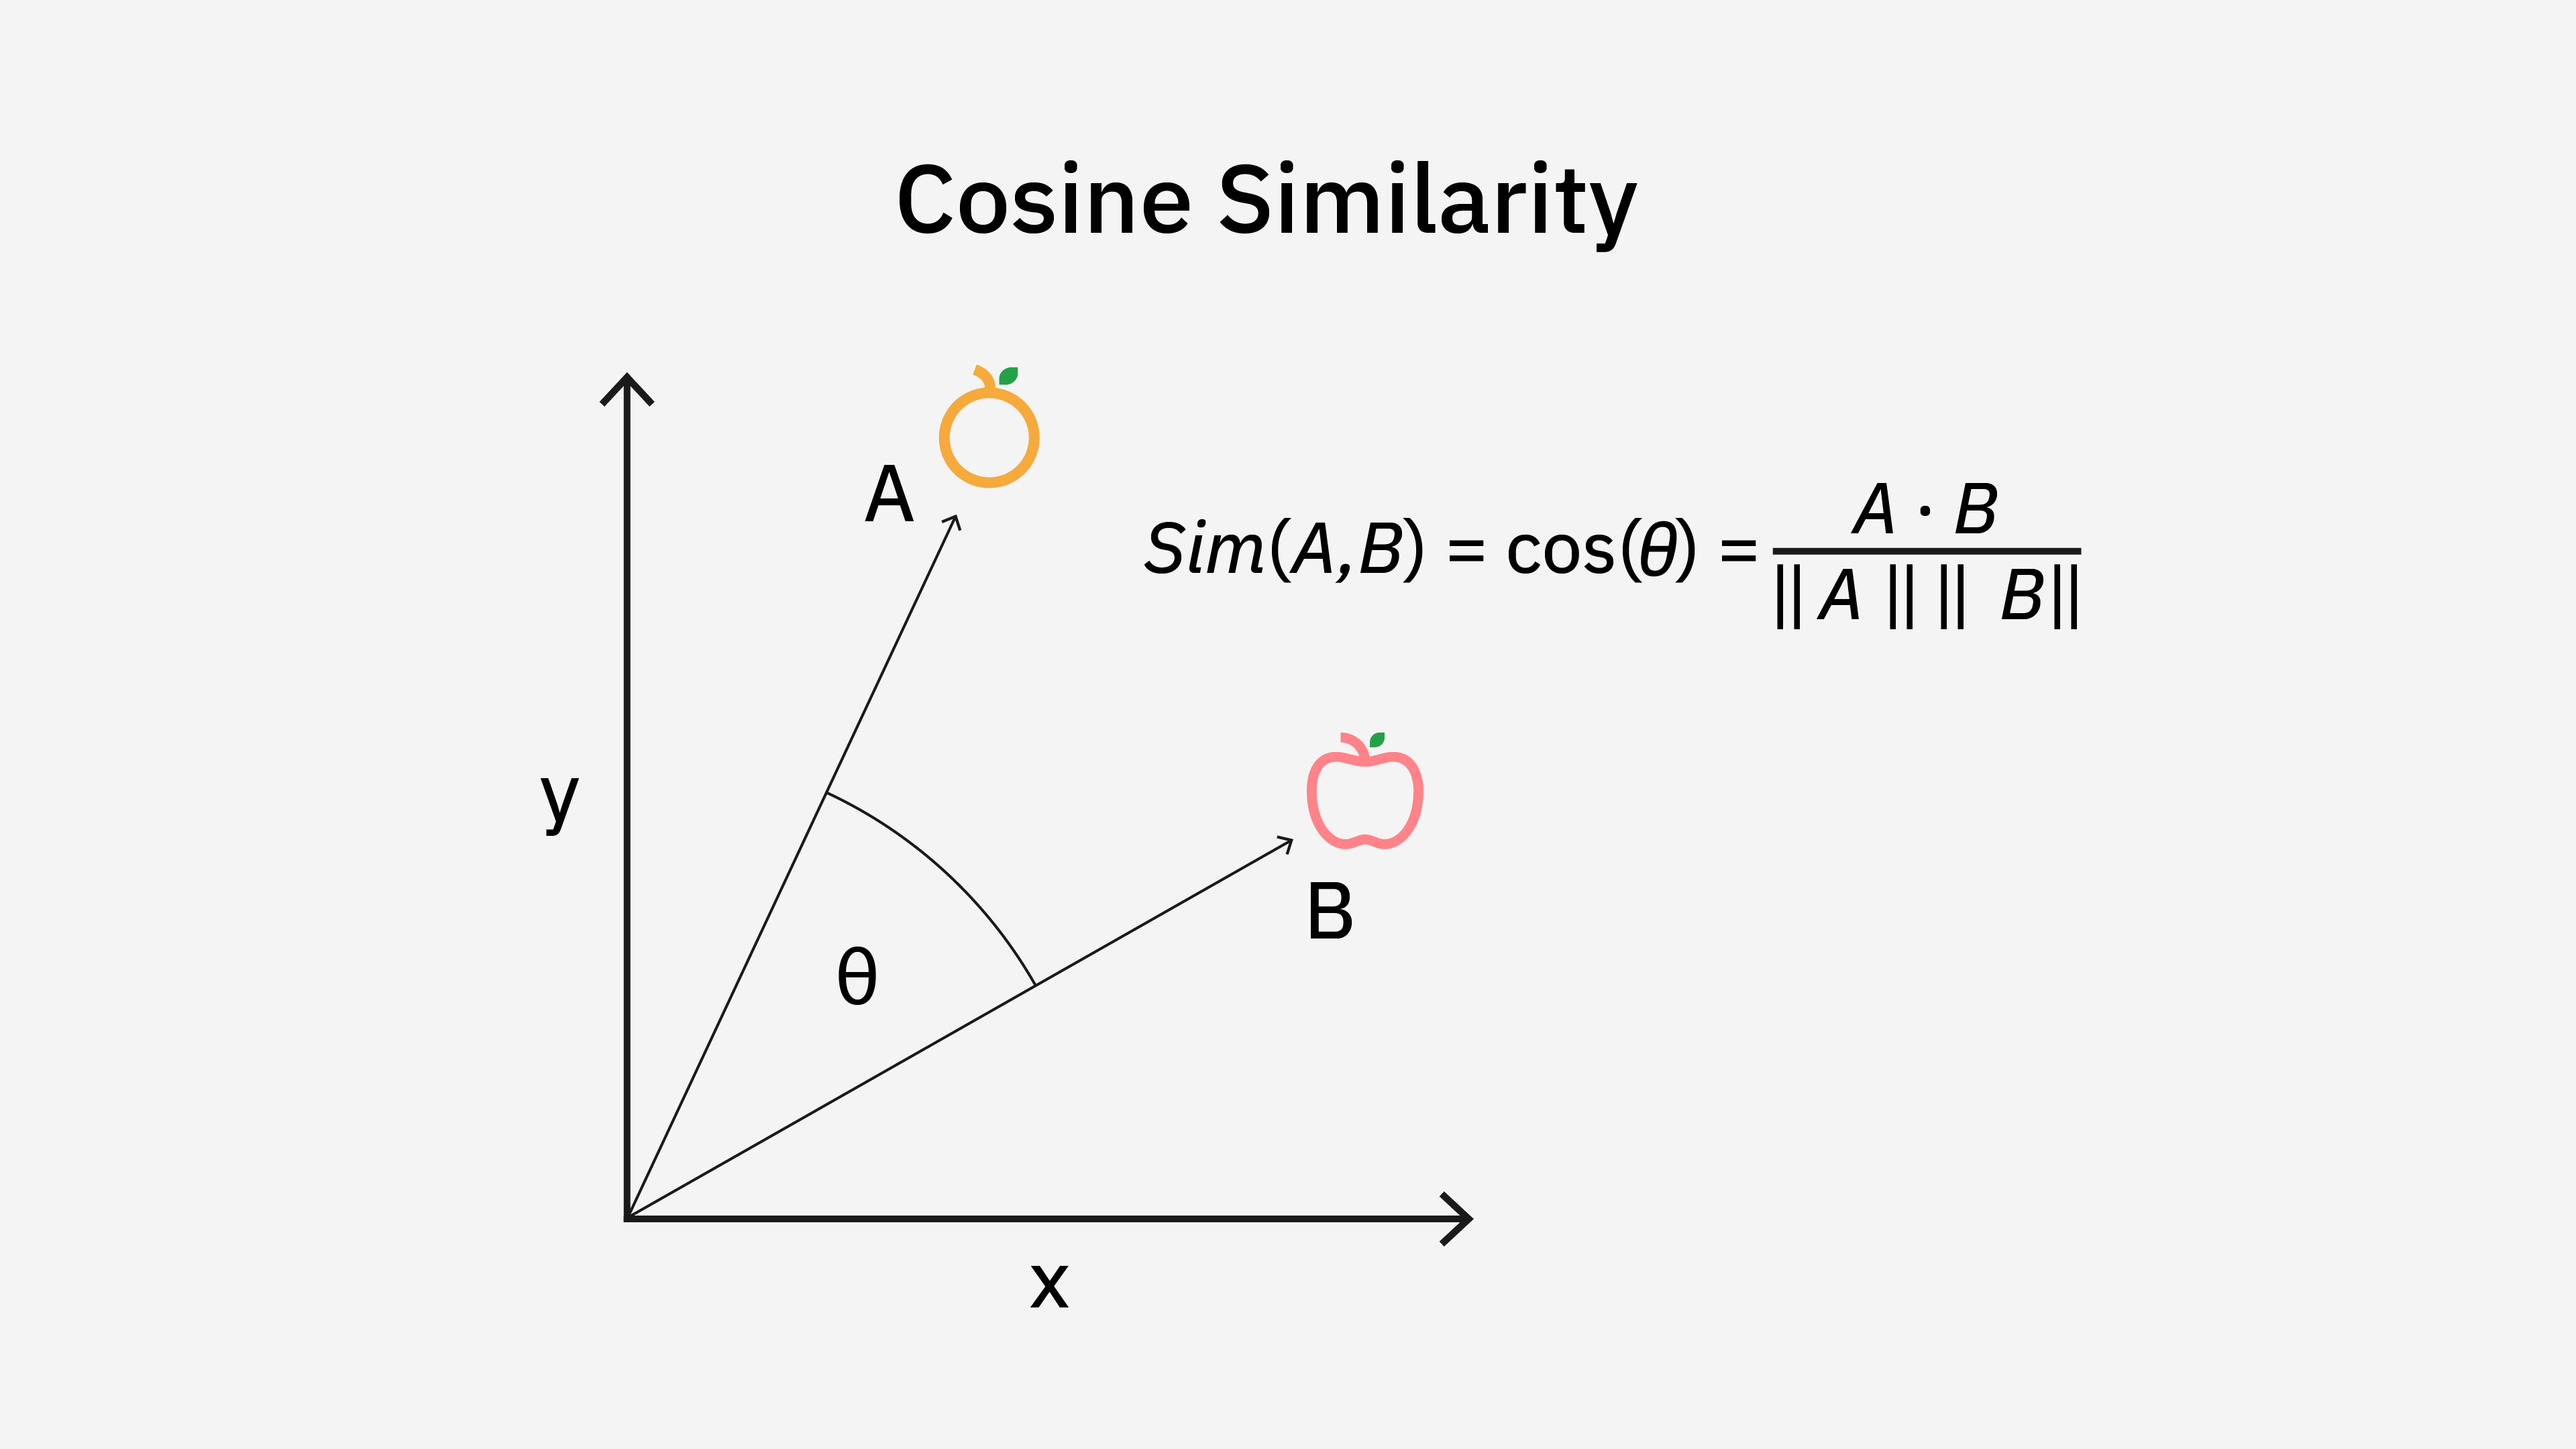

This metric quantifies the **angular proximity** between two word vectors—higher values indicate stronger semantic similarity.  
Additionally, the cell retrieves **nearest neighbors** for selected seed words to qualitatively assess how well each model captures contextual relationships in the Azerbaijani corpus.  

> *Source:* [IBM Think Topics — “What is Vector Search?”](https://www.ibm.com/think/topics/vector-search)


In [15]:
import pandas as pd
from gensim.models import Word2Vec, FastText
import re
from numpy import dot
from numpy.linalg import norm

w2v = Word2Vec.load("embeddings/word2vec.model")
ft  = FastText.load("embeddings/fasttext.model")

seed_words = [
    "yaxşı", "pis", "çox", "bahalı", "ucuz",
    "mükəmməl", "dəhşət", "<PRICE>", "<RATING_POS>"
]

syn_pairs = [("yaxşı", "əla"), ("bahalı", "qiymətli"), ("ucuz", "sərfəli")]
ant_pairs = [("yaxşı", "pis"), ("bahalı", "ucuz")]


def lexical_coverage(model, tokens):
    vocab = model.wv.key_to_index
    return sum(1 for t in tokens if t in vocab) / max(1, len(tokens))

files = [
    "labeled-sentiment_2col.xlsx",
    "test__1__2col.xlsx",
    "train__3__2col.xlsx",
    "train-00000-of-00001_2col.xlsx",
    "merged_dataset_CSV__1__2col.xlsx",
]

def read_tokens(path):
    df = pd.read_excel(path, usecols=["cleaned_text"])
    return [t for row in df["cleaned_text"].astype(str) for t in row.split()]

print("== Lexical coverage (per dataset) ==")
for f in files:
    toks = read_tokens(f)
    cov_w2v = lexical_coverage(w2v, toks)
    cov_ftv = lexical_coverage(ft, toks)
    print(f"{f}: W2V={cov_w2v:.3f}, FT(vocab)={cov_ftv:.3f}")

def cos(a, b):
    return float(dot(a, b) / (norm(a) * norm(b)))

def pair_sim(model, pairs):
    vals = []
    for a, b in pairs:
        try:
            vals.append(model.wv.similarity(a, b))
        except KeyError:
            pass
    return (sum(vals) / len(vals)) if vals else float("nan")

syn_w2v = pair_sim(w2v, syn_pairs)
syn_ft  = pair_sim(ft,  syn_pairs)
ant_w2v = pair_sim(w2v, ant_pairs)
ant_ft  = pair_sim(ft,  ant_pairs)

print("\n== Similarity (higher better for synonyms; lower better for antonyms) ==")
print(f"Synonyms:  W2V={syn_w2v:.3f}, FT={syn_ft:.3f}")
print(f"Antonyms:  W2V={ant_w2v:.3f}, FT={ant_ft:.3f}")
print(f"Separation (Syn - Ant): W2V={(syn_w2v - ant_w2v):.3f}, "
      f"FT={(syn_ft - ant_ft):.3f}")

def neighbors(model, word, k=5):
    try:
        return [w for w, _ in model.wv.most_similar(word, topn=k)]
    except KeyError:
        return []

print("\n== Nearest neighbors (qualitative) ==")
for w in seed_words:
    print(f"  W2V NN for '{w}':", neighbors(w2v, w))
    print(f"  FT  NN for '{w}':", neighbors(ft,  w))


== Lexical coverage (per dataset) ==
labeled-sentiment_2col.xlsx: W2V=0.932, FT(vocab)=0.932
test__1__2col.xlsx: W2V=0.987, FT(vocab)=0.987
train__3__2col.xlsx: W2V=0.990, FT(vocab)=0.990
train-00000-of-00001_2col.xlsx: W2V=0.943, FT(vocab)=0.943
merged_dataset_CSV__1__2col.xlsx: W2V=0.949, FT(vocab)=0.949

== Similarity (higher better for synonyms; lower better for antonyms) ==
Synonyms:  W2V=0.358, FT=0.437
Antonyms:  W2V=0.328, FT=0.427
Separation (Syn - Ant): W2V=0.030, FT=0.009

== Nearest neighbors (qualitative) ==
  W2V NN for 'yaxşı': ['iyi', '<RATING_POS>', 'yaxshi', 'yaxsı', 'doğramayıb']
  FT  NN for 'yaxşı': ['yaxşıı', 'yaxşıkı', 'yaxşıca', 'yaxş', 'yaxşıya']
  W2V NN for 'pis': ['günd', 'vərdişlərə', 'bakıkartı', 'bugunki', 'gündedi']
  FT  NN for 'pis': ['piis', 'pisdii', 'pi', 'pisə', 'pisi']
  W2V NN for 'çox': ['gözəldir', 'çöx', 'bəyənilsin', 'çoxx', 'çoox']
  FT  NN for 'çox': ['çoxçox', 'çoxx', 'çoxh', 'ço', 'çoh']
  W2V NN for 'bahalı': ['yaxtaları', 'metallarla', 

The next cell visualizes the **comparative benchmark** between *Word2Vec* and *FastText* embeddings by plotting cosine similarity scores for synonym and antonym word pairs, along with their separation metric.
The bar chart provides an intuitive view of each model's semantic discrimination ability — higher synonym similarity and lower antonym similarity indicate better embedding quality, while the separation value (Syn - Ant) quantifies the model's overall semantic consistency.

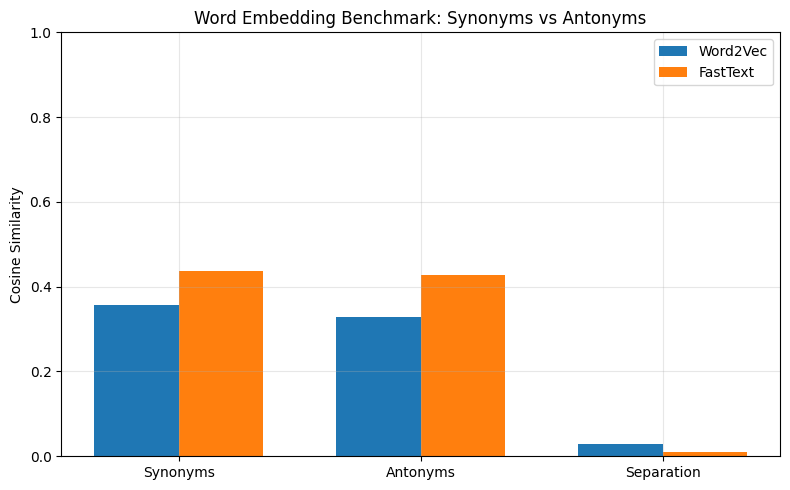

In [16]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ["Synonyms", "Antonyms", "Separation"]
w2v_scores = [syn_w2v, ant_w2v, syn_w2v - ant_w2v]
ft_scores  = [syn_ft,  ant_ft,  syn_ft  - ant_ft]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, w2v_scores, width, label="Word2Vec", color="#1f77b4")
plt.bar(x + width/2, ft_scores,  width, label="FastText", color="#ff7f0e")

plt.ylabel("Cosine Similarity")
plt.title("Word Embedding Benchmark: Synonyms vs Antonyms")
plt.xticks(x, metrics)
plt.ylim(0, 1)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


**Interpretation:**  
The bar chart compares cosine similarity scores for synonym and antonym word pairs across the two embedding models.  
FastText slightly outperforms Word2Vec in both synonym and antonym similarity, indicating a stronger overall representation of semantic relationships.  
However, the small separation value (Syn-Ant) suggests that both models capture general semantic proximity but still struggle to distinctly separate opposing meanings.

For the next cell, higher ***mean neighbor similarity*** indicates that semantically related words cluster more tightly in the vector space - suggesting greater local consistency of embeddings.  

The bar plot compares Word2Vec and FastText in this respect, with FastText generally achieving denser neighborhood structures due to its subword modeling.

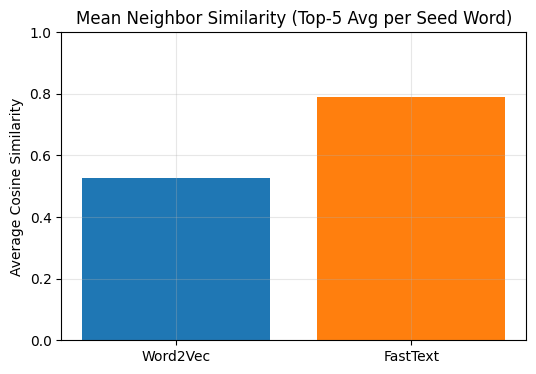

Mean Top-5 similarity — W2V: 0.528, FT: 0.790


In [17]:
def mean_neighbor_distance(model, words, k=5):
    dists = []
    for w in words:
        try:
            sims = [sim for _, sim in model.wv.most_similar(w, topn=k)]
            dists.append(np.mean(sims))
        except KeyError:
            pass
    return np.mean(dists) if dists else float("nan")

mean_nn_w2v = mean_neighbor_distance(w2v, seed_words)
mean_nn_ft  = mean_neighbor_distance(ft,  seed_words)

plt.figure(figsize=(6,4))
plt.bar(["Word2Vec", "FastText"], [mean_nn_w2v, mean_nn_ft],
        color=["#1f77b4", "#ff7f0e"])
plt.title("Mean Neighbor Similarity (Top-5 Avg per Seed Word)")
plt.ylabel("Average Cosine Similarity")
plt.ylim(0, 1)
plt.grid(alpha=0.3)
plt.show()

print(f"Mean Top-5 similarity — W2V: {mean_nn_w2v:.3f}, FT: {mean_nn_ft:.3f}")

**t-SNE** is used because it helps us **visualize high-dimensional embeddings** (like 300-dimensional Word2Vec or FastText vectors) in a **2-D space** while preserving their relative similarities.
In simpler terms, t-SNE projects similar words close together and dissimilar ones farther apart, allowing us to **see the semantic structure and clustering behavior** of the models that would otherwise be hidden in high-dimensional space.


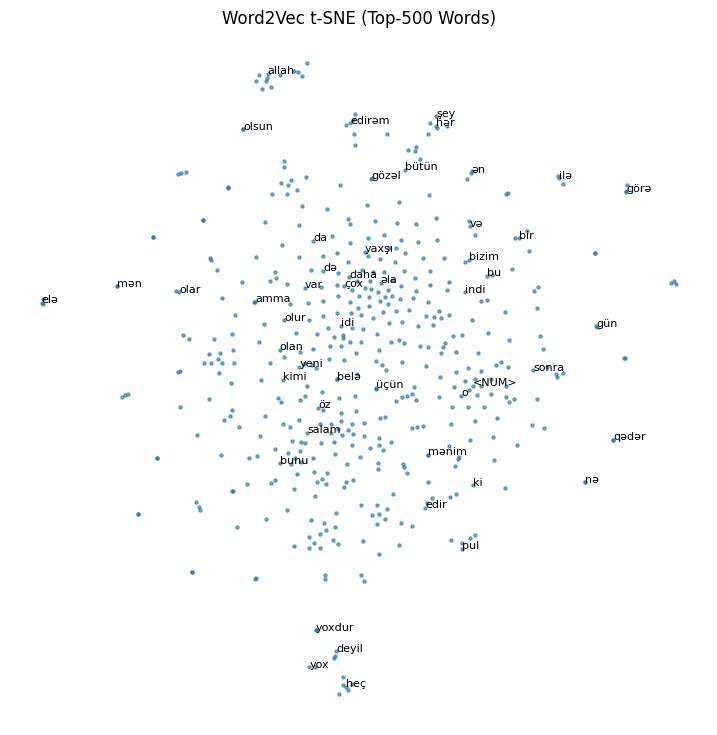

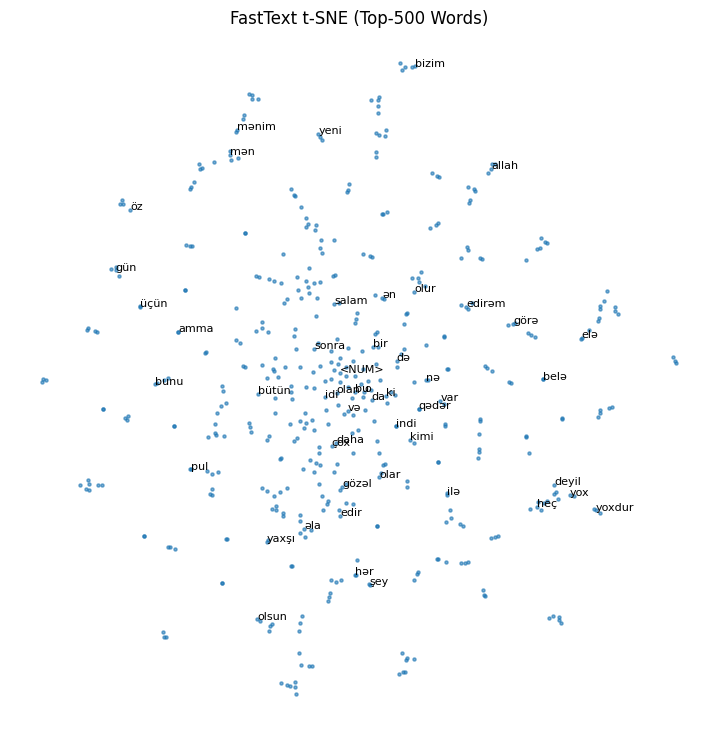

In [18]:
from sklearn.manifold import TSNE

def tsne_visualize(model, title="Model t-SNE", topn=500):
    vocab = list(model.wv.key_to_index.keys())[:topn]
    X = np.vstack([model.wv[w] for w in vocab])
    tsne = TSNE(n_components=2, perplexity=5, init="pca",
                learning_rate="auto", random_state=42)
    Y = tsne.fit_transform(X)

    plt.figure(figsize=(9,9))
    plt.scatter(Y[:,0], Y[:,1], s=5, alpha=0.6)
    for i, w in enumerate(vocab[:50]):
        plt.text(Y[i,0], Y[i,1], w, fontsize=8)
    plt.title(title)
    plt.axis("off")
    plt.show()

tsne_visualize(w2v, "Word2Vec t-SNE (Top-500 Words)")
tsne_visualize(ft,  "FastText t-SNE (Top-500 Words)")


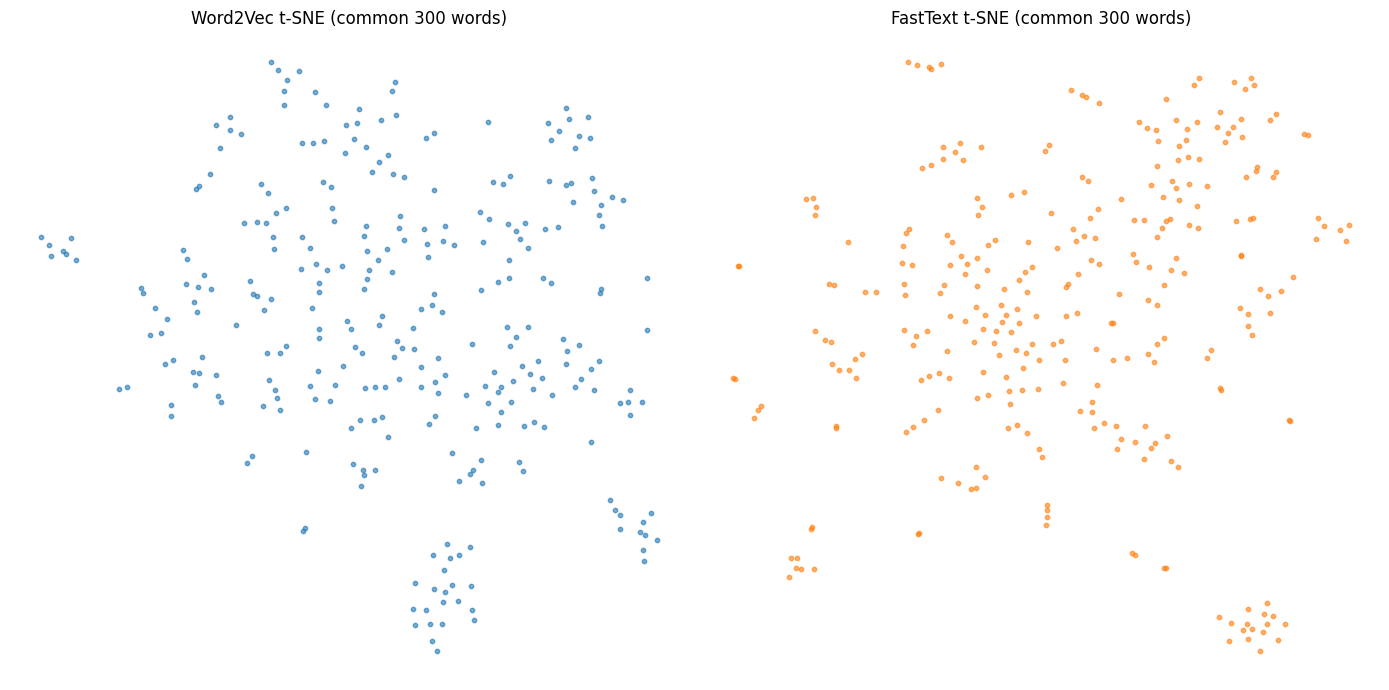

In [19]:
common_vocab = list(set(w2v.wv.key_to_index.keys()) & set(ft.wv.key_to_index.keys()))
common_vocab = common_vocab[:300]

X_w2v = np.vstack([w2v.wv[w] for w in common_vocab])
X_ft  = np.vstack([ft.wv[w]  for w in common_vocab])

tsne = TSNE(n_components=2, perplexity=5, init="pca",
            learning_rate="auto", random_state=42)
Y_w2v = tsne.fit_transform(X_w2v)

tsne_ft = TSNE(n_components=2, perplexity=5, init="pca",
               learning_rate="auto", random_state=42)
Y_ft = tsne_ft.fit_transform(X_ft)

fig, axes = plt.subplots(1, 2, figsize=(14,7))
axes = axes.ravel()

axes[0].scatter(Y_w2v[:,0], Y_w2v[:,1], s=10, c="#1f77b4", alpha=0.6)
axes[0].set_title("Word2Vec t-SNE (common 300 words)")
axes[0].axis("off")

axes[1].scatter(Y_ft[:,0], Y_ft[:,1], s=10, c="#ff7f0e", alpha=0.6)
axes[1].set_title("FastText t-SNE (common 300 words)")
axes[1].axis("off")

plt.tight_layout()
plt.show()


Above figure compares **Word2Vec** and **FastText** based on *how their word clusters are organized.*

- In the *Word2Vec* (left), clusters are smaller and clearly separated, showing that the model groups similar words tightly but leaves more space between different clusters.

- In the *FastText* (right), clusters are larger and more connected, meaning the model links related words more smoothly — likely because it also uses subword information.

# **Conclusion**

The **t-SNE** visualizations reveal that both *Word2Vec* and *FastText* capture meaningful semantic relationships but differ in how they structure their embedding spaces. Word2Vec tends to form tighter and more isolated clusters, suggesting sharper separations between semantic groups. In contrast, FastText exhibits broader and more connected clusters, reflecting smoother transitions between related words — a result of its subword-level understanding. These distinctions are summarized below:

| Feature                         | Word2Vec                                           | FastText                                           |
| ------------------------------- | -------------------------------------------------- | -------------------------------------------------- |
| Clustering density              | More compact with clear separations between groups | Broader, overlapping clusters with smoother links  |
| Morphological generalization    | Weak; limited to full-word representations         | Strong; captures subword and morphological cues    |
| Representation of rare words    | Weaker due to missing token dependency             | Better coverage through subword composition        |
| Semantic discrimination ability | Distinct clusters but less generalization          | More coherent and contextually consistent clusters |


**Note:**

During the understanding of the core concept, as well as the interpretation of code and figures, occasional deep web searches were utilized to support the analysis.